<center><a target="_blank" href="http://www.propulsion.academy"><img src="https://drive.google.com/uc?id=1McNxpNrSwfqu1w-QtlOmPSmfULvkkMQV" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Classification Models - Tackling Class Imbalance (Live coding) </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>Propulsion Academy, 2021</center>

# Classification Models - Tackling Class Imbalance (Live coding)

__Topic covered__

- Logistic Regression
- Resampling using SMOTENC
- Resampling using RandomUnderSampler
- Class imbalance with class weights
- Classification Metrics
- ROC curve score and plotting

In [1]:
import imblearn

In [2]:
# run this cell if you don't have imblearn installed

#!pip install imblearn --ignore-installed

# Load Dependencies

In [201]:
import numpy as np
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC # for oversampling the minority class, i.e generating synthetic samples
from imblearn.under_sampling import RandomUnderSampler # for undersampling the majority class

__Helper function__

<span style="color:orange">**The helper function below will plot the ROC curve, calculate AUC for a base model and the AUC of our logistic regression model.**</span>

In [4]:
def plot_roc(y_test, proba_preds):

    # create linear line
    base_probs = [0 for _ in range(len(y_test))]

    base_auc = roc_auc_score(y_test, base_probs)
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) # roc curve for the dummy model
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds) # roc curve for your model

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Loading Dataset


We can pre-load the dataset with specific values (e.g., ?) depicting missing values (NaNs)



In [137]:
##Load Data
orig_url='https://drive.google.com/file/d/1tW4tLhWYQiLXrpPOLjvYJGmooKWannAH/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

df = pd.read_csv(dwn_url)
#df.info()
#df.isnull()
# dropping unnecessary column
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [139]:
data=df.drop(columns=['Unnamed: 0', 'customerID'])
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [140]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
5981    False
5982    False
5983    False
5984    False
5985    False
Name: TotalCharges, Length: 5986, dtype: bool

In [208]:
data[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [209]:
df1 = data[data.TotalCharges!=' ']
df1.shape

(5976, 20)

In [210]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [211]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


In [145]:
df1.TotalCharges.values


array([1734.65, 3973.2 , 2869.85, ...,  306.05, 1200.15,  457.3 ])

In [146]:
X = df1.drop(columns=['Churn'])
y = df1.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((4780, 19), (1196, 19))

# Visualization 


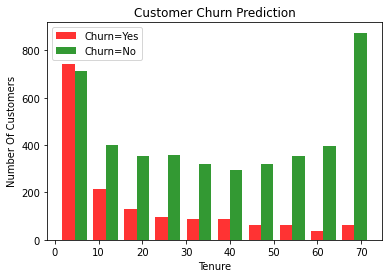

In [263]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("Tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction")

plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'],label=['Churn=Yes','Churn=No'], alpha=0.8)
plt.legend();

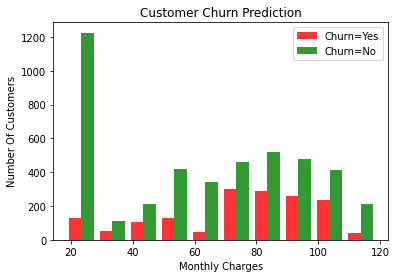

In [264]:
churn_no = df1[df1.Churn=='No'].MonthlyCharges      
churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction")

plt.hist([churn_yes, churn_no], color=['red', 'green'],label=['Churn=Yes','Churn=No'], alpha=0.8)
plt.legend();

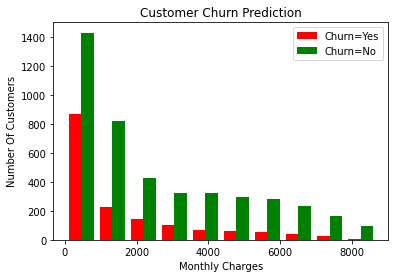

In [265]:
tc_churn_no = df1[df1.Churn=='No'].TotalCharges      
tc_churn_yes = df1[df1.Churn=='Yes'].TotalCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction")

plt.hist([tc_churn_yes, tc_churn_no],  color=['red', 'green'],label=['Churn=Yes','Churn=No'])
plt.legend();

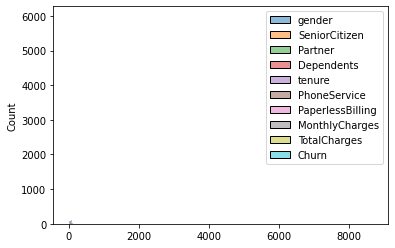

In [266]:
sns.histplot(df2)

In [249]:
df2=df1.drop(columns=['MultipleLines'])
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,Yes,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


In [250]:
for column in df2:
            if df2[column].dtypes=='object':
                print(f'{column}: {df2[column].unique()}') 

gender: ['Male' 'Female']
Partner: ['Yes' 'No']
Dependents: ['Yes' 'No']
PhoneService: ['Yes' 'No']
InternetService: ['No' 'Fiber optic' 'DSL']
OnlineSecurity: ['No internet service' 'No' 'Yes']
OnlineBackup: ['No internet service' 'Yes' 'No']
DeviceProtection: ['No internet service' 'Yes' 'No']
TechSupport: ['No internet service' 'No' 'Yes']
StreamingTV: ['No internet service' 'Yes' 'No']
StreamingMovies: ['No internet service' 'No' 'Yes']
Contract: ['Two year' 'Month-to-month' 'One year']
PaperlessBilling: ['No' 'Yes']
PaymentMethod: ['Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check'
 'Mailed check']
Churn: ['No' 'Yes']


In [251]:
yes_no_columns = ['Partner','Dependents','PhoneService','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df2[col].replace({'Yes': 1,'No': 0},inplace=True)

df2['gender'].replace({'Female':1,'Male':0},inplace=True)



In [252]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,1,72,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),24.10,1734.65,0
1,1,0,0,0,44,1,Fiber optic,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0
2,1,1,1,0,38,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1
3,0,0,0,0,4,1,DSL,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0
4,0,0,0,0,2,1,DSL,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0


In [254]:
df3 = pd.get_dummies(data=df2, columns=['InternetService','Contract','PaymentMethod'])
df3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,72,1,No internet service,No internet service,No internet service,No internet service,...,0,0,1,0,0,1,0,1,0,0
1,1,0,0,0,44,1,0,1,1,0,...,0,1,0,1,0,0,0,1,0,0
2,1,1,1,0,38,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,0,0,0,0,4,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,0,0,0,0,2,1,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0


In [255]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df3[cols_to_scale] = scaler.fit_transform(df3[cols_to_scale])

In [236]:
df2 = df1[['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling',
        'MonthlyCharges', 'TotalCharges']]
correlations = df2.corrwith(df1.Churn)
correlations = correlations[correlations!=1]
positive_correlations = correlations[
correlations >0].sort_values(ascending = False)
negative_correlations =correlations[
correlations<0].sort_values(ascending = False)
print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)

TypeError: ignored

In [235]:
#g = sns.FacetGrid(df1, row='TotalCharges', col='gender', hue='Churn', height=3.5)
#g.map(plt.scatter, 'tenure', 'TotalCharges', alpha=0.6)
#g.add_legend();

# Training a Logistic Regression Model with Pipelines

We will show all the major steps needed to train your first classification model using sklearn pipelines which often makes the code more concise and you need lesser lines of code.

## Split Dataset into train and test Datsets

We split the dataset into a standard 70:30 train-test split using stratified sampling to keep the distributions of classes similar in train and test datasets

In [147]:
X = df1.drop(columns=['Churn'])
y = df1['Churn']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((4780, 19), (1196, 19))

In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 5064 to 5070
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4780 non-null   object 
 1   SeniorCitizen     4780 non-null   int64  
 2   Partner           4780 non-null   object 
 3   Dependents        4780 non-null   object 
 4   tenure            4780 non-null   int64  
 5   PhoneService      4780 non-null   object 
 6   MultipleLines     4780 non-null   object 
 7   InternetService   4780 non-null   object 
 8   OnlineSecurity    4780 non-null   object 
 9   OnlineBackup      4780 non-null   object 
 10  DeviceProtection  4780 non-null   object 
 11  TechSupport       4780 non-null   object 
 12  StreamingTV       4780 non-null   object 
 13  StreamingMovies   4780 non-null   object 
 14  Contract          4780 non-null   object 
 15  PaperlessBilling  4780 non-null   object 
 16  PaymentMethod     4780 non-null   objec

<span style="color:orange"> **We first want to check how balanced our data is. We can use the buildin function 'value_counts' to do this.**</span>

In [150]:
y_train.value_counts()

No     3511
Yes    1269
Name: Churn, dtype: int64

In [151]:
y_test.value_counts()

No     878
Yes    318
Name: Churn, dtype: int64

## Separate categorical and numeric columns

We will need to treat these features separately just like before

In [152]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

## Define Categorical Transformer Pipeline

Consists of the series of steps needed to tranform the categorical features. This includes: 

- Constant imputer to fill missing values
- One-hot encoder to get dummy variables

In [153]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available')),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])
categorical_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='Not Available',
                               strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

## Define Numeric Transformer Pipeline

Consists of the series of steps needed to tranform the numeric features. This includes: 

- K-nearest neighbor imputer to fill missing values
- Standard Scaler to scale the numeric features 

In [154]:
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

numeric_transformer

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler())])

## Define Column Transformer Pipeline for preprocessing

Consists of the series of steps needed to tranform all the features in sequence

- Numeric Transfomer defined earlier
- Categorical Transfomer defined earlier

In [155]:
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'Available',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                 

## Initialize Logistic Regression Model

In [156]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

LogisticRegression(random_state=42, solver='liblinear')

## Build Modeling Pipeline

Chains the following steps:

- Preprocessing pipeline steps defined earlier
- Logistic Regression model defined earlier

In [157]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor), 
                              ("model", lr_model)
                              ])
pipeline_lr

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                       

## Train and Evaluate Logistic Regression ML Pipeline

In [158]:
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)

In [159]:
class_labels = pipeline_lr.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,No,Yes
No,788,90
Yes,152,166


In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87       878
         Yes       0.65      0.52      0.58       318

    accuracy                           0.80      1196
   macro avg       0.74      0.71      0.72      1196
weighted avg       0.79      0.80      0.79      1196



In [206]:
pickle.dump(lr_model, open("lr_avinash.sav", 'wb'))

# Training Logistic Regression Pipeline by handling Class Imbalance

<span style="color:orange"> **After we split our data into the training and testing sets, we ONLY resample the Training data to achieve a more balanced training for our model. Here we use 2 types of sampling methods:**</span>

<span style="color:orange"> **1. SMOTENC**</span> <br>
<span style="color:orange"> **2. RandomUnderSampler**</span>

In [161]:
X = df1.drop(columns=['Churn'])
y = df1['Churn']

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((4780, 19), (1196, 19))

In [163]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 5064 to 5070
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4780 non-null   object 
 1   SeniorCitizen     4780 non-null   int64  
 2   Partner           4780 non-null   object 
 3   Dependents        4780 non-null   object 
 4   tenure            4780 non-null   int64  
 5   PhoneService      4780 non-null   object 
 6   MultipleLines     4780 non-null   object 
 7   InternetService   4780 non-null   object 
 8   OnlineSecurity    4780 non-null   object 
 9   OnlineBackup      4780 non-null   object 
 10  DeviceProtection  4780 non-null   object 
 11  TechSupport       4780 non-null   object 
 12  StreamingTV       4780 non-null   object 
 13  StreamingMovies   4780 non-null   object 
 14  Contract          4780 non-null   object 
 15  PaperlessBilling  4780 non-null   object 
 16  PaymentMethod     4780 non-null   objec

In [164]:
y_train.value_counts()

No     3511
Yes    1269
Name: Churn, dtype: int64

In [165]:
X_train.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5064,Female,0,Yes,Yes,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.2,1277.75
5311,Male,0,No,No,36,Yes,No,DSL,No,Yes,No,Yes,No,Yes,One year,Yes,Mailed check,65.4,2498.40
4118,Female,1,Yes,No,26,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98.1,2510.70


__SMOTENC__

In [166]:
X_train.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [167]:
categorical_feature_idxs = np.where(X_train.dtypes == "object")[0]
categorical_feature_idxs

array([ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [168]:
X_train.columns[categorical_feature_idxs]

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [169]:
smtnc = SMOTENC(categorical_features=categorical_feature_idxs) # initialize the SMOTEENC object
X_train_smote, y_train_smote = smtnc.fit_resample(X_train, y_train) # try to generate new samples

In [170]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
features = X_train.columns

In [171]:
categorical_features, numeric_features

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

In [172]:
# pipeline 1: fill in missing values for categorical features
categorical_imputer = Pipeline(steps=[
                              ("cat_imputer", SimpleImputer(strategy='constant',
                                                            fill_value='Not Available'))
                              ])
# pipeline 2: fill in missing values for numeric features
numeric_imputer = Pipeline(steps=[
                                  ("knn_imputer", KNNImputer(n_neighbors=5))
                                  ])
# combine both pipelines to apply to specific columns in the dataframe
imputer = ColumnTransformer(transformers=[
                                          ("num", numeric_imputer, 
                                                  numeric_features),
                                          ("cat", categorical_imputer, 
                                                  categorical_features)
                                          ])
imputer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'Available',
                                                                strategy='constant'))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'Stream

In [173]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 5064 to 5070
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4780 non-null   object 
 1   SeniorCitizen     4780 non-null   int64  
 2   Partner           4780 non-null   object 
 3   Dependents        4780 non-null   object 
 4   tenure            4780 non-null   int64  
 5   PhoneService      4780 non-null   object 
 6   MultipleLines     4780 non-null   object 
 7   InternetService   4780 non-null   object 
 8   OnlineSecurity    4780 non-null   object 
 9   OnlineBackup      4780 non-null   object 
 10  DeviceProtection  4780 non-null   object 
 11  TechSupport       4780 non-null   object 
 12  StreamingTV       4780 non-null   object 
 13  StreamingMovies   4780 non-null   object 
 14  Contract          4780 non-null   object 
 15  PaperlessBilling  4780 non-null   object 
 16  PaymentMethod     4780 non-null   objec

In [174]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5064,Female,0,Yes,Yes,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.20,1277.75
5311,Male,0,No,No,36,Yes,No,DSL,No,Yes,No,Yes,No,Yes,One year,Yes,Mailed check,65.40,2498.40
4118,Female,1,Yes,No,26,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98.10,2510.70
2337,Female,0,Yes,No,49,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,100.85,4847.35
3928,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,No,Electronic check,77.85,299.20


In [175]:
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train, columns=numeric_features+categorical_features)
X_train[numeric_features] = X_train[numeric_features].astype('int64')
X_train = X_train[features]

X_test = pd.DataFrame(X_test, columns=numeric_features+categorical_features)
X_test[numeric_features] = X_test[numeric_features].astype('int64')
X_test = X_test[features]

In [176]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4780 entries, 0 to 4779
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            4780 non-null   object
 1   SeniorCitizen     4780 non-null   int64 
 2   Partner           4780 non-null   object
 3   Dependents        4780 non-null   object
 4   tenure            4780 non-null   int64 
 5   PhoneService      4780 non-null   object
 6   MultipleLines     4780 non-null   object
 7   InternetService   4780 non-null   object
 8   OnlineSecurity    4780 non-null   object
 9   OnlineBackup      4780 non-null   object
 10  DeviceProtection  4780 non-null   object
 11  TechSupport       4780 non-null   object
 12  StreamingTV       4780 non-null   object
 13  StreamingMovies   4780 non-null   object
 14  Contract          4780 non-null   object
 15  PaperlessBilling  4780 non-null   object
 16  PaymentMethod     4780 non-null   object
 17  MonthlyCharges

In [177]:
categorical_feature_idxs

array([ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [178]:
smtnc = SMOTENC(categorical_features=categorical_feature_idxs)
X_train_smote, y_train_smote = smtnc.fit_resample(X_train, y_train)

In [179]:
X_train_smote = pd.DataFrame(X_train_smote, columns=features)
X_train_smote.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,Yes,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20,1277
1,Male,0,No,No,36,Yes,No,DSL,No,Yes,No,Yes,No,Yes,One year,Yes,Mailed check,65,2498
2,Female,1,Yes,No,26,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98,2510
3,Female,0,Yes,No,49,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,100,4847
4,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,No,Electronic check,77,299


In [180]:
X_train.shape, X_train_smote.shape

((4780, 19), (7022, 19))

In [181]:
y_train.value_counts()

No     3511
Yes    1269
Name: Churn, dtype: int64

In [182]:
y_train_smote.value_counts()

No     3511
Yes    3511
Name: Churn, dtype: int64

In [202]:
pipeline_lr.fit(X_train_smote, y_train_smote)

y_pred = pipeline_lr.predict(X_test)

In [203]:
class_labels = pipeline_lr.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,No,Yes
No,678,200
Yes,90,228


In [204]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.88      0.77      0.82       878
         Yes       0.53      0.72      0.61       318

    accuracy                           0.76      1196
   macro avg       0.71      0.74      0.72      1196
weighted avg       0.79      0.76      0.77      1196



In [207]:
pickle.dump(pipeline_lr, open("lr_SMOTENC_avinash.sav", 'wb'))

In [ ]:
plot_model(ipeline_lr)

__Resampling RandomUnderSampler__

In [183]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [184]:
y_train_rus.value_counts()

No     1269
Yes    1269
Name: Churn, dtype: int64

In [185]:
X_train_rus = pd.DataFrame(X_train_rus, columns=features)
X_train_rus.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,Yes,Yes,27,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),85,2151
1,Female,0,No,No,18,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71,1247
2,Female,1,Yes,Yes,22,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),85,1961
3,Male,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,115,8425
4,Female,0,No,No,71,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),77,5550


__Create Pipeline__



In [186]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available')),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [187]:
pipeline_l_regr = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", lr_model)])

# Recap: No Resampling

<span style="color:orange"> **Let's first run a model without resampling the data.**</span> <br>

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((4780, 19), (1196, 19))

In [189]:
pipeline_l_regr.fit(X_train, y_train)
pred_no_resample = pipeline_l_regr.predict(X_test)

<span style="color:orange"> **To evaluate our model, we do:**</span> 

<span style="color:green"> *1. Confusion Matrix*</span> <br>
<span style="color:green"> *2. Classification report*</span> <br>
<span style="color:green"> *3. ROC and AUC*</span> <br>

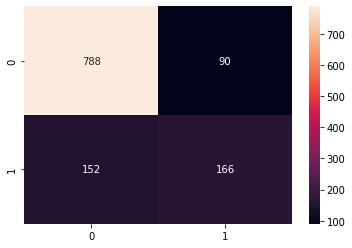

In [190]:
cf = confusion_matrix(y_test, pred_no_resample)
sns.heatmap(cf, annot=True, fmt='.0f');

In [191]:
cf

array([[788,  90],
       [152, 166]])

In [192]:
print(classification_report(y_test, pred_no_resample))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87       878
         Yes       0.65      0.52      0.58       318

    accuracy                           0.80      1196
   macro avg       0.74      0.71      0.72      1196
weighted avg       0.79      0.80      0.79      1196



In [193]:
pipeline_l_regr.classes_

array(['No', 'Yes'], dtype=object)

In [194]:
y_test[:10]

4418    No
1658    No
2300    No
4157    No
5572    No
196     No
381     No
4642    No
4119    No
1570    No
Name: Churn, dtype: object

In [195]:
y_test_encoded = [0 if item == '0' else 1 for item in y_test]
y_test_encoded[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [196]:
pipeline_l_regr.predict(X_test)[:10]

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

In [197]:
pipeline_l_regr.classes_

array(['No', 'Yes'], dtype=object)

In [198]:
pipeline_l_regr.predict_proba(X_test)[:10]

array([[0.72536543, 0.27463457],
       [0.64228756, 0.35771244],
       [0.66345952, 0.33654048],
       [0.96972315, 0.03027685],
       [0.97488161, 0.02511839],
       [0.99643228, 0.00356772],
       [0.81498143, 0.18501857],
       [0.7803191 , 0.2196809 ],
       [0.55190635, 0.44809365],
       [0.864224  , 0.135776  ]])

In [199]:
pipeline_l_regr.predict_proba(X_test)[:, 1]

array([0.27463457, 0.35771244, 0.33654048, ..., 0.04190991, 0.01445558,
       0.6079774 ])

In [221]:
proba_pred_no_resampling = pipeline_l_regr.predict_proba(X_test)
plot_roc(y_test_encoded, proba_pred_no_resampling)

ValueError: ignored

# Tackling Imbalance with Class weights

In [ ]:
y_train.value_counts()

In [ ]:
l_regr2 = LogisticRegression(class_weight={0: 1, 
                                           1: 3}, 
                             random_state=42,
                             solver='liblinear'
                             )

pipeline_l_regr2 = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", l_regr2)])

In [ ]:
pipeline_l_regr2.fit(X_train, y_train)
pred_no_resample2 = pipeline_l_regr2.predict(X_test)

In [ ]:
cf = confusion_matrix(y_test, pred_no_resample2)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_no_resample2))

In [ ]:
proba_pred_class_wts = pipeline_l_regr2.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_class_wts)

# Tackling Imbalance with SMOTE resampling

In [ ]:
pipeline_l_regr

In [ ]:
y_train_smote.value_counts()

In [ ]:
pipeline_l_regr.fit(X_train_smote, y_train_smote)
pred_smote = pipeline_l_regr.predict(X_test)

In [ ]:
cf = confusion_matrix(y_test, pred_smote)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_smote))

In [ ]:
proba_pred_smote = pipeline_l_regr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_smote)

# Tackling Imbalance with RandomUnderSampler

In [ ]:
y_train_rus.value_counts()

In [ ]:
pipeline_l_regr.fit(X_train_rus, y_train_rus)
pred_rus = pipeline_l_regr.predict(X_test)

In [ ]:
cf = confusion_matrix(y_test, pred_rus)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_rus))

In [ ]:
prob_pred_rus = pipeline_l_regr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, prob_pred_rus)

In [ ]:
pipeline_l_regr.predict_proba()

In [ ]:
ns_fpr, ns_tpr, thres = roc_curve(y_test_encoded, prob_pred_rus)

In [ ]:
pd.DataFrame({
    'FPR': ns_fpr,
    'TPR': ns_tpr,
    'Thresh': thres
}).head(30)